In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance (other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')

        def backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = backward

        return out

    def __truediv__(self, other):
        return self * (other**-1)

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad  += (1 - t**2) * out.grad
        out._backward = _backward

        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

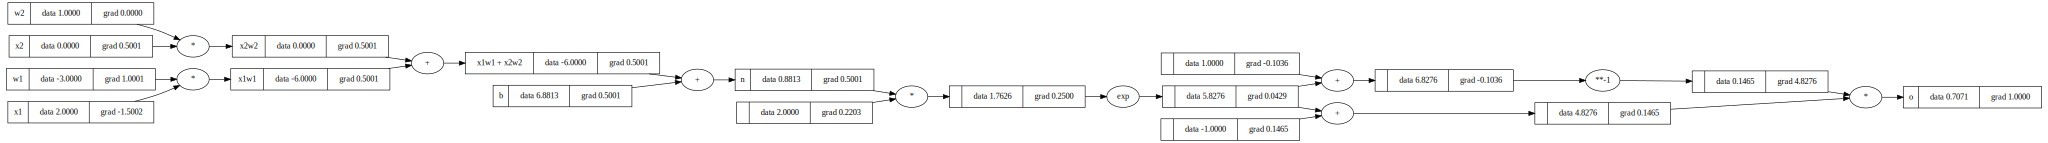

In [ ]:
# nueron model
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'

# Apply tanh
e = (2*n).exp()
o = (e - 1) / (e + 1) ; o.label = 'o'

o.backward()
draw_dot(o)

In [ ]:
# Identical implimentation using PyTorch
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requres_grad = torch.Tensor

b = torch.Tensor([6.6813]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

0.5923639877920166


In [ ]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
         act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
         out = act.tanh()
         return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)

        return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
len(n.parameters())

41

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.2822927794846644)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(2000):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.0018788830101926254
1 0.001875584569985163
2 0.0018722973742830763
3 0.0018690213660683941
4 0.001865756488706859
5 0.001862502685944702
6 0.0018592599019054872
7 0.0018560280810869321
8 0.0018528071683577855
9 0.001849597108954762
10 0.0018463978484794267
11 0.0018432093328952731
12 0.0018400315085246011
13 0.0018368643220456127
14 0.001833707720489485
15 0.00183056165123743
16 0.0018274260620177987
17 0.001824300900903286
18 0.0018211861163080546
19 0.0018180816569849268
20 0.0018149874720226678
21 0.0018119035108432363
22 0.0018088297231989758
23 0.0018057660591700463
24 0.0018027124691617092
25 0.0017996689039016715
26 0.0017966353144375005
27 0.0017936116521340265
28 0.0017905978686707852
29 0.001787593916039478
30 0.0017845997465414578
31 0.0017816153127852364
32 0.0017786405676840206
33 0.001775675464453321
34 0.0017727199566084468
35 0.0017697739979621544
36 0.0017668375426222955
37 0.0017639105449894726
38 0.0017609929597546246
39 0.001758084741896843
40 0.0017551858466810

In [ ]:
ypred

[Value(data=0.9895803142739562),
 Value(data=-0.9870604554856987),
 Value(data=-0.9929188155486177),
 Value(data=0.9916290555899546)]